## **Generative Adversarial Network (GAN)**

- สำหรับ notebook นี้เราจะมาลองเขียน GAN สำหรับ generate ภาพกัน โดยเราจะใช้โค้ดตัวอย่างจาก [DCGAN Tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html) ของ Pytorch
- ชุดข้อมูลสามารถเข้าไป Download ได้จาก http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html

## ชุดข้อมูล CelebA

เราใช้ `datasets` ในการอ่าน `ImageFolder` ทำการ resize ให้เหลือขนาด 64 x 64 (ตามตัวอย่าง) แล้วจากนั้นใช้ `DataLoader` อ่านภาพออกมาเป็น batch แล้วพล็อตดูว่าแต่ละ batch มีภาพอะไรบ้าง

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

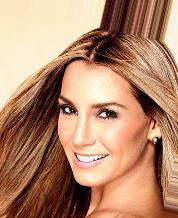

In [3]:
Image.open("../gan_data/img_align_celeba/000001.jpg")

In [4]:
img_size = 64
dataset = datasets.ImageFolder(
    root="../gan_data/",
    transform=transforms.Compose([
        transforms.Resize(img_size),
        transforms.CenterCrop(img_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
)

In [5]:
dataloader = DataLoader(
    dataset, batch_size=64,
    shuffle=True, num_workers=2
)

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

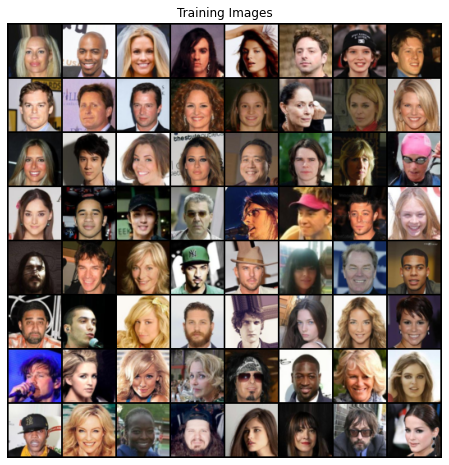

In [8]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(
    np.transpose(
        vutils.make_grid(
            real_batch[0].to(device),
            padding=2, normalize=True
        ).cpu(),
        (1, 2, 0)
    )
)
plt.show()

## **สร้าง Deep Convolutional Generative Adversarial Network (DCGAN)**

In [9]:
# ในเปเปอร์ DCGAN
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [10]:
# Generator
class Generator(nn.Module):
    def __init__(self, nz: int = 100, ngf: int = 64, nc: int = 3):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf * 2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [12]:
nz = 100
generator = Generator(nz=nz, ngf=64, nc=3)
generator.apply(weights_init) # เปลี่ยน weight initialization
generator.to(device)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [13]:
# ทดลอง ConvTranspose2d
z = torch.randn(1, 100, 1, 1)
convt = nn.ConvTranspose2d(100, 64 * 8, 4)
convt(z).shape

torch.Size([1, 512, 4, 4])

In [14]:
ngf = 64
convt2 = nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False)

In [15]:
z2 = convt(z)

In [16]:
z2.shape

torch.Size([1, 512, 4, 4])

In [17]:
convt2(z2).shape

torch.Size([1, 256, 8, 8])

In [18]:
# ทดลองสร้าง noise ขนาด 8 x 100 x 1 x 1 และใส่เข้าไปใน generator
noise = torch.randn(8, nz, 1, 1, device=device)
print(noise.shape)

torch.Size([8, 100, 1, 1])


In [19]:
out_generator = generator(noise)

In [20]:
out_generator.shape

torch.Size([8, 3, 64, 64])

In [21]:
class Discriminator(nn.Module):
    def __init__(self, nc: int = 3, ndf: int = 64):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    def forward(self, input):
        return self.main(input)

In [22]:
discriminator = Discriminator(nc=3, ndf=64)
discriminator.apply(weights_init)
discriminator.to(device)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [24]:
criterion = nn.BCELoss()
fixed_noise = torch.randn(64, 100, 1, 1, device=device)
real_label = 1.
fake_label = 0.
lr = 2e-3
optimizerD = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

## **Training**

In [25]:
img_list = []
G_losses, D_losses = [], []
iters = 0

n_epochs = 5
for epoch in range(n_epochs):
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # สร้าง real labels สำหรับ discriminator
        discriminator.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = discriminator(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # สร้าง batch ของ latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device) # สร้าง latent vector
        fake = generator(noise)  # สร้างภาพจาก latent vector
        label.fill_(fake_label) # ใส่ fake label (0)
        output = discriminator(fake.detach()).view(-1) # ใส่ภาพ fake ที่สร้างขึ้นผ่าน discriminator
        errD_fake = criterion(output, label) # คำนวณ loss
        errD_fake.backward()  # อัพเดทพารามิเตอร์
        D_G_z1 = output.mean().item() 
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        generator.zero_grad()
        label.fill_(real_label)
        output = discriminator(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, n_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == n_epochs - 1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = generator(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
        iters += 1

[0/5][0/3166]	Loss_D: 1.7641	Loss_G: 30.9508	D(x): 0.4354	D(G(z)): 0.4846 / 0.0000
[0/5][50/3166]	Loss_D: 4.1487	Loss_G: 9.2954	D(x): 0.9350	D(G(z)): 0.3979 / 0.0004
[0/5][100/3166]	Loss_D: 0.4343	Loss_G: 4.7061	D(x): 0.8050	D(G(z)): 0.0281 / 0.0282
[0/5][150/3166]	Loss_D: 1.5570	Loss_G: 1.5257	D(x): 0.4033	D(G(z)): 0.0963 / 0.3311
[0/5][200/3166]	Loss_D: 1.8852	Loss_G: 2.1841	D(x): 0.7371	D(G(z)): 0.7038 / 0.1507
[0/5][250/3166]	Loss_D: 1.1580	Loss_G: 2.0352	D(x): 0.7048	D(G(z)): 0.5015 / 0.1997
[0/5][300/3166]	Loss_D: 2.0239	Loss_G: 1.0319	D(x): 0.3844	D(G(z)): 0.3865 / 0.4390
[0/5][350/3166]	Loss_D: 1.6869	Loss_G: 1.1323	D(x): 0.3603	D(G(z)): 0.2959 / 0.3695
[0/5][400/3166]	Loss_D: 1.4724	Loss_G: 1.0323	D(x): 0.4778	D(G(z)): 0.3575 / 0.3957
[0/5][450/3166]	Loss_D: 1.0266	Loss_G: 2.2770	D(x): 0.6514	D(G(z)): 0.2369 / 0.1546
[0/5][500/3166]	Loss_D: 1.0838	Loss_G: 1.5156	D(x): 0.6196	D(G(z)): 0.3459 / 0.2663
[0/5][550/3166]	Loss_D: 1.3051	Loss_G: 1.3301	D(x): 0.4544	D(G(z)): 0.2734 / 0

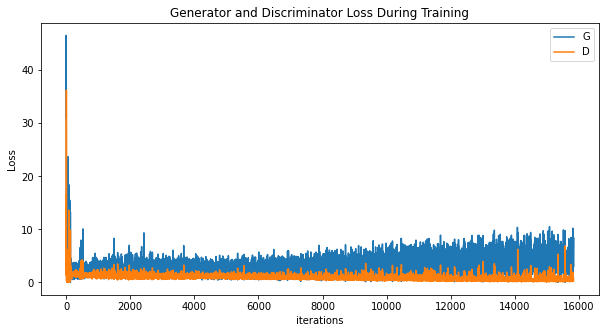

In [26]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

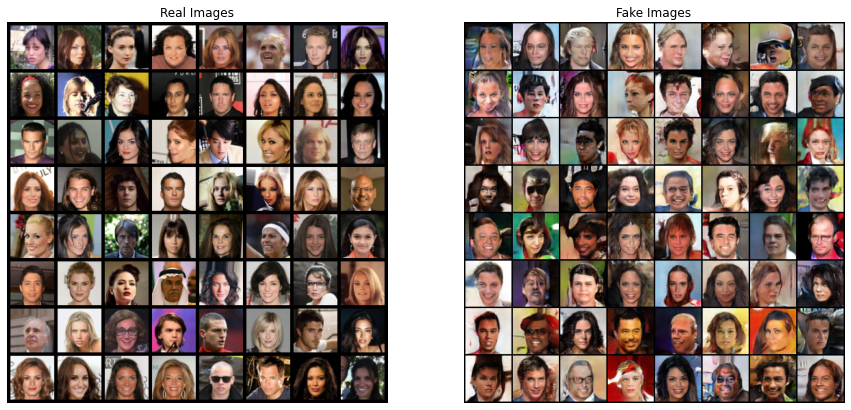

In [27]:
# ภาพจริง
real_batch = next(iter(dataloader))
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# ภาพหลอก
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()